In [1]:
import underworld as uw
import underworld.function as fn
from underworld import UWGeodynamics as GEO
import numpy as np
import math

import os
import h5py   
import matplotlib.pyplot as plt

from underworld import visualisation as vis
u = GEO.UnitRegistry


loaded rc file /opt/venv/lib/python3.10/site-packages/underworld/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
name_bcs = "_FreeSlipBotm"
fdir_output = "op2_Zhong2000NMCase1"+name_bcs

xmin_box,xmax_box = -2000,2000   # unit [km]
ymin_box,ymax_box = -3000,0      # unit [km]


x_box = xmax_box-xmin_box
y_box = ymax_box-ymin_box

 
x_res,y_res = 1600,1200
npoints = 1600
dx = x_box/x_res
dy = y_box/y_res
    
conv_vel = 1.5 * u.centimeter / u.year  # 3.0  * u.centimeter / u.year /2

# dt = 2.5 * u.kiloyear
# Total_Convergence  = 500 *u.kilometer
# Total_Time = (Total_Convergence / conv_vel).to(u.megayear)

#scaling
ref_velocity = 1.5 * u.centimeter / u.year
ref_density = 3300. * u.kilogram / u.meter**3
ref_length = 1000. * u.kilometer  
ref_gravity =  10.0 * u.meter / u.second**2
gravity = 10.0 * u.meter / u.second**2
#ref_vicosity = 1e21 * u.pascal * u.second

T0 = 273.15 * u.degK  # 0 * u.degC
Tz = 1573.15 * u.degK # 1300 * u.degC at litho bottom
# Tz = 1300 + 273.15 + (-ymin_box-ml_thickness)*120

bodyforce = ref_density * ref_gravity
KL = ref_length
Kt = KL / ref_velocity
KM = bodyforce * KL**2 * Kt**2
KT = (Tz - T0)

# ref_velocity = 1. * u.centimeter / u.year
# ref_density = 3300. * u.kilogram / u.meter**3
# ref_length = 1000. * u.kilometer  
# ref_gravity =  10.0 * u.meter / u.second**2
# gravity = 10. * u.meter / u.second**2
# ref_vicosity = 1e21 * u.pascal * u.second

# T0 = 273.15 * u.degK  # 0 * u.degC
# Tz = 1573.15 * u.degK # 1300 * u.degC at litho bottom
# # Tz = 1300 + 273.15 + (-ymin_box-ml_thickness)*120

# bodyforce = ref_density * ref_gravity
# KL = ref_length
# KM = ref_density*KL**3
# Kt = KM/(KL*ref_vicosity)
# KT = (Tz - T0)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT
    
dx_nd = GEO.nd(dx*u.kilometer)
dy_nd = GEO.nd(dy*u.kilometer)

In [3]:
# Model = GEO.Model(elementRes=(x_res, y_res),
#                   minCoord=(0. * u.kilometer, ymin_box*u.kilometer),
#                   maxCoord=(xmax_box*u.kilometer, ymax_box*u.kilometer),
#                   gravity=(0.0, -gravity))
# Model.minStrainRate = 1e-18 / u.second

minCoord = (GEO.nd(xmin_box*u.kilometer),GEO.nd(ymin_box*u.kilometer))
maxCoord = (GEO.nd(xmax_box*u.kilometer),GEO.nd(ymax_box*u.kilometer))

meshCopy = uw.mesh.FeMesh_Cartesian(elementType='Q1/dQ0',
                                    elementRes=(x_res,y_res),
                                    minCoord=minCoord,
                                    maxCoord=maxCoord)

	Global element size: 1600x1200
	Local offset of rank 0: 0x0
	Local range of rank 0: 1600x1200


In [4]:
def load_mesh(fdir,meshCopy,step,remesh=False):
    if remesh:
        meshfile = fdir+"mesh-"+ str(step)+".h5"
        meshCopy.load(meshfile)
    else:
        meshfile = fdir+"mesh"+".h5"
        meshCopy.load(meshfile)
    return meshCopy
    
def load_mesh_variable(fdir,step,meshCopy,name,nodeDofCount):
    variableCopy =meshCopy.add_variable(nodeDofCount) 
    variablefile = fdir+ name + str(step) +'.h5'
    variableCopy.load(variablefile)
    return variableCopy

def load_swarm(fdir,meshCopy,step):
    swarmCopy = uw.swarm.Swarm(mesh=meshCopy,particleEscape=True)
    swarmfile = fdir+'swarm-' + str(step)  +'.h5'
    swarmCopy.load(swarmfile)
    return swarmCopy

def load_swarm_variable(fdir,step,swarmCopy,name,dataType,count):
    variableCopy = swarmCopy.add_variable(dataType, count)
    variablefile = fdir+ name + str(step)+'.h5'
    variableCopy.load(variablefile)
    return variableCopy

def load_tracer(fdir,step,name):
    fname = fdir + name + str(step) + ".h5"
    fh5   = h5py.File(fname ,'r')  
    fdata = fh5["data"][()]
    return fdata

In [5]:
def loadtopo_max(fdir,meshCopy,maxstep,dstep):
    depth_max = []
    for step in range(0,maxstep,dstep):
        mesh = load_mesh(fdir,meshCopy,step,remesh=True)
        top = mesh.specialSets[ 'Top_VertexSet'] 
        ycoord = mesh.data[top.data, 1]
        depth_max.append(ycoord.max())  
    return np.array(depth_max)

def loadtopo_max_index(fdir,meshCopy,maxstep,dstep,index,KL):
    depth_max = []
    depth_index = []
    for step in range(0,maxstep,dstep):
        mesh = load_mesh(fdir,meshCopy,step,remesh=True)
        top = mesh.specialSets[ 'Top_VertexSet'] 
        ycoord = mesh.data[top.data, 1] 
        depth_max.append(ycoord.max()) 
        depth_index.append(ycoord[index])
    return np.array(depth_index)*KL,np.array(depth_max)*KL

def loadtopo(fdir,meshCopy,step,KL):
    mesh = load_mesh(fdir,meshCopy,step,remesh=True)
    top = mesh.specialSets[ 'Top_VertexSet'] 
    coords = mesh.data[top.data, :]*KL  
    return coords

In [6]:
def load_mesh_top(fdir,meshCopy,step):
    mesh_tem = load_mesh(fdir,meshCopy,step,remesh=True)
    top = mesh_tem.specialSets['Top_VertexSet']
    return mesh_tem.data[top]

In [9]:
fdir1 = "op2_Zhong2000NMCase1_FreeSlipBotm_fixlr/"
case_name = "Case1_FreeSlipBotm_"

steps = [0,1,2]
#steps = [0,10,20]
dt = 10

#coords_topo1 = load_tracer(fdir1,step,"Surf-") 
#x_topo1,y_topo1 = coords_topo1[:,0],coords_topo1[:,1]

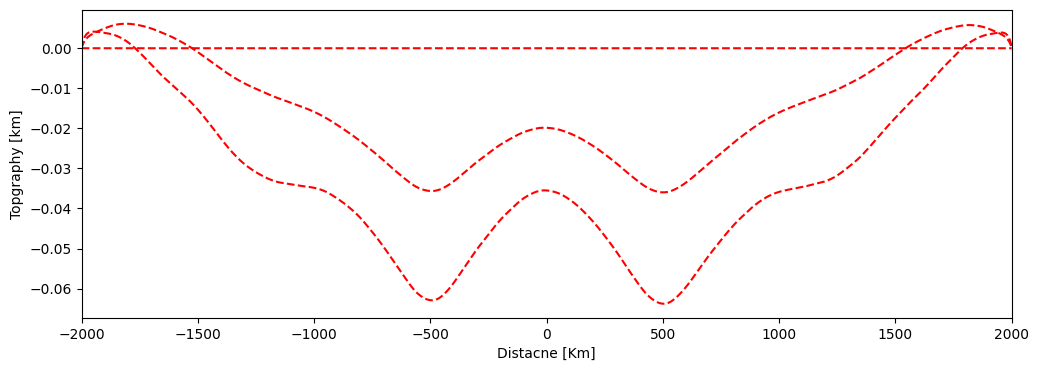

In [11]:
fname = "Topography-" #+str(step)
fig, ax1 = plt.subplots(nrows=1, figsize=(12,4))
ax1.set(xlabel='Distacne [Km]', ylabel='Topgraphy [km]') 
ax1.set_xlim([xmin_box,xmax_box])
for i,step in enumerate(steps):
    Time = step*dt
    coords = load_mesh_top(fdir1,meshCopy,step)*ref_length.m
    ax1.plot(coords[:,0],coords[:,1],"r--",label="NM_FreeSlipBotm")
    #coords = load_mesh_top(fdir1,meshCopy,step)*ref_length.m
    #ax1.plot(coords[:,0]+600,coords[:,1],"b--",label="NM_LithoBotm")
    #coords = load_mesh_top(fdir1,meshCopy,step)*ref_length.m
    #ax1.plot(coords[:,0],coords[:,1],"b-",label="Vel")
    #ax1.plot(data_x+600,data_surf[:,i+1],"k-",label="Analytic_FreeSurfBotm")
    #ax1.plot(data_x,data_surf[::-1,i+1],"k-")
    #plt.text(0,coords[:,1].max() , str(Time)+" ka", ha='center',fontsize=10, color='k')
#ax1.legend(loc='upper right')
fig.savefig(case_name+"topo")   

In [ ]:
case_name = "testx_Case1ForVelBc_"

data_x = np.loadtxt(case_name+"topo_x.txt")
data_moho = np.loadtxt(case_name+"topo_m_time.txt")
data_surf = np.loadtxt(case_name+"topo_s_time.txt")
data_botm = np.loadtxt(case_name+"topo_b_time.txt")

In [ ]:
fname = "Topography-" #+str(step)
fig, ax1 = plt.subplots(nrows=1, figsize=(12,4))
ax1.set(xlabel='Distacne [Km]', ylabel='Topgraphy [km]') 
ax1.set_xlim([xmin_box,xmax_box])
for i,step in enumerate(steps):
    Time = step*dt
    #coords = load_mesh_top(fdir,meshCopy,step)*ref_length.m
    #ax1.plot(coords[:,0],coords[:,1],"r-",label="Vel")
    #coords = load_mesh_top(fdir1,meshCopy,step)*ref_length.m
    #ax1.plot(coords[:,0],coords[:,1],"b-",label="Vel")
    ax1.plot(data_x,data_surf[:,i],"k-",label="Vel")
    #ax1.plot(data_x-600,data_surf[::-1,i],"k-",label="Vel")
    plt.text(0.,data_surf[:,i].max(), str(Time)+" ka", ha='center',fontsize=10, color='k')
fig.savefig("case_name+topo")   

In [ ]:
fname = "Moho-" #+str(step)
fig, ax1 = plt.subplots(nrows=1, figsize=(12,4))
ax1.set(xlabel='Distacne [Km]', ylabel='Moho [km]') 
ax1.set_xlim([xmin_box,xmax_box])
for i,step in enumerate(steps):
    Time = step*dt
    #coords = coords_topo2 = load_tracer(fdir,step,"Moho-") 
    #ax1.plot(coords[:,0],coords[:,1]+35,"r-",label="Vel")
    ax1.plot(data_x,data_moho[:,i],"k-",label="Vel") 
    plt.text(0.,data_moho[:,i].min(), str(Time)+" ka", ha='center',fontsize=10, color='k')
fig.savefig("case_name+moho")   

In [ ]:
# fdir = fdir1

# meshCopy = load_mesh(fdir,meshCopy,step,remesh=False)
# swarmCopy = load_swarm(fdir,meshCopy,step)
# materialField = load_swarm_variable(fdir,step,swarmCopy,"materialField-",dataType="int",count=1)
# velocityField = load_mesh_variable(fdir,step,meshCopy,"velocityField-",nodeDofCount=2)


In [ ]:
# fig_res = (1000,400)

# Fig = vis.Figure(resolution=fig_res,rulers=True,margin = 80,rulerticks=7,quality=3,clipmap=False)
# #Fig.Points(Model.Moho_tracers, pointSize=4.0)
# #Fig.Points(Model.LAB_tracers, pointSize=4.0)
# Fig.Points(swarmCopy, materialField,fn_size=4.0,discrete=True,colourBar=False)
# Fig.VectorArrows(meshCopy, velocityField) 
# Fig.show()
# #Fig.save("Model-Ref2Wedge_velbc_"+str(step)+".png")

In [ ]:
# air_idx = 1
# volume = swarmCopy.particleCoordinates.data 
# coords = volume[np.where(materialField.data[:,0]==air_idx)]
# x_nd,z_nd = coords[:,0],coords[:,1]
# x,z = GEO.dimensionalise(coords[:,0],u.kilometer),GEO.dimensionalise(coords[:,1],u.kilometer)

In [ ]:
# fig, ax1 = plt.subplots(nrows=1, figsize=(20,4))
# ax1.set(xlabel='Distacne [Km]', ylabel='Topgraphy [km]') 
# #ax1.plot(x_topo,y_topo,'k',label = "topo")
# ax1.scatter(x,z,c="k")
# #ax1.scatter(x_topo,y_topo,c="r")
# ax1.scatter(x_topo1,y_topo1,c="y")
# #ax1.scatter(x_test,z_test,c="b")
# #ax1.scatter(x_test2,y_test2,c="g")
# #ax1.legend()